<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Dinosaurus_Island_Character_level_language_model_final_v3a_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character level language model - Dinosaurus Island

Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely! 



Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into the dataset To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 



In [1]:
!wget 'https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/5-%20Sequence%20Models/Week%201/Dinosaur%20Island%20--%20Character-level%20language%20model/dinos.txt'
!wget 'https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/5-%20Sequence%20Models/Week%201/Dinosaur%20Island%20--%20Character-level%20language%20model/shakespeare.txt'

--2022-09-02 20:23:44--  https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/5-%20Sequence%20Models/Week%201/Dinosaur%20Island%20--%20Character-level%20language%20model/dinos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [text/plain]
Saving to: ‘dinos.txt’

dinos.txt           100%[===================>]  19.44K  --.-KB/s    in 0.001s  

2022-09-02 20:23:44 (35.8 MB/s) - ‘dinos.txt’ saved [19909/19909]

--2022-09-02 20:23:44--  https://raw.githubusercontent.com/furkanu/deeplearning.ai-pytorch/master/5-%20Sequence%20Models/Week%201/Dinosaur%20Island%20--%20Character-level%20language%20model/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133,

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Play with data

In [4]:
data = open('dinos.txt', 'r').read()
data= data.lower()
lines = data.splitlines() 
print(lines[:10])

['aachenosaurus', 'aardonyx', 'abdallahsaurus', 'abelisaurus', 'abrictosaurus', 'abrosaurus', 'abydosaurus', 'acanthopholis', 'achelousaurus', 'acheroraptor']


In [5]:
lines[0][1:]

'achenosaurus'

In [6]:
lines[0]+'\n'

'aachenosaurus\n'

In [7]:
vocab = sorted(set(data))
vocab_size = len(vocab)
print(vocab,vocab_size)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 27


In [8]:
ch_to_idx = {c:i for i,c in enumerate(vocab)}
print(ch_to_idx)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [9]:
idx_to_ch = {i:c for i,c in enumerate(vocab)}
print(idx_to_ch)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [10]:
line = 'achenosaurus'
x_str = line
y_str = line[1:] + '\n' # without first character and with \n at the end
x = torch.zeros((len(x_str),vocab_size), dtype=torch.float)
y = torch.zeros(len(y_str), dtype=torch.long)

for i,(x_ch,y_ch) in enumerate(zip(x_str,y_str)):
  print(i)
  print(x_ch,y_ch)
  break

0
a c


In [11]:
for i,(x_ch,y_ch) in enumerate(zip(x_str,y_str)):
  x[i][ch_to_idx[x_ch]] = 1
  y[i] = ch_to_idx[y_ch]

y

tensor([ 3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0])

#Preparing the Data

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained in the picture below:

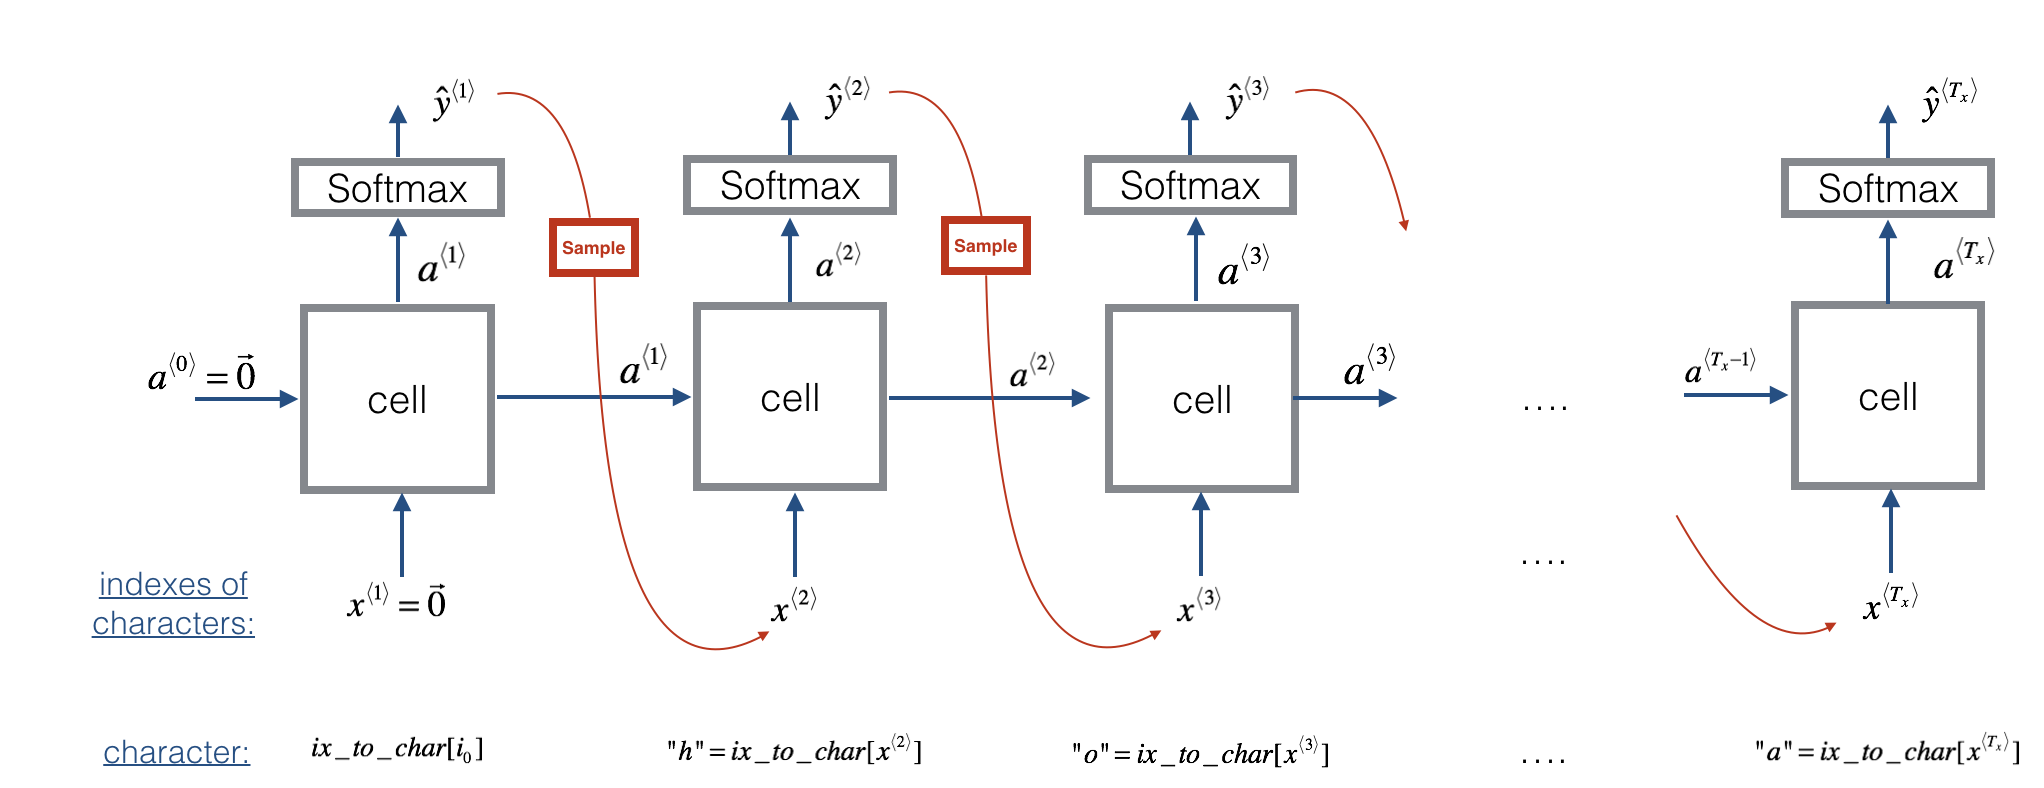
<caption><center> **Figure 3**: In this picture, we assume the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time step, and have the network sample one character at a time. </center></caption>
For each timestep (that is, for each letter in a training word) the inputs of the network will be (current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<\n>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “\n”).

(L,N,H_in) when batch_first=False or (N,L,H_in) when batch_first=True

  
N = batch size

L = sequence length

H_in = input_size


In [12]:
class DinosDataset(Dataset):
  def __init__(self):
    super().__init__()
    data = open('dinos.txt')
    content = data.read().lower()
    self.vocab = sorted(set(content))
    self.vocab_size = len(self.vocab)
    self.lines = content.splitlines()
    self.ch_to_idx = {c:i for i,c in enumerate(self.vocab)}
    self.idx_to_ch = {i:c for i,c in enumerate(self.vocab)}

  def __getitem__(self,index):
    line = self.lines[index]
    x_str = line
    y_str = line[1:] + '\n' # without first character and with \n at the end
    x = torch.zeros((len(x_str),self.vocab_size), dtype=torch.float)
    y = torch.zeros(len(y_str), dtype=torch.long)

    for i,(x_ch,y_ch) in enumerate(zip(x_str,y_str)):
      x[i][ch_to_idx[x_ch]] = 1
      y[i] = ch_to_idx[y_ch]
    
    return x,y

  def __len__(self):
    return len(self.lines)


In [13]:
train_data = DinosDataset()
data_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [14]:
x,y = next(iter(data_loader))
print(x.shape,y.shape)

torch.Size([1, 15, 27]) torch.Size([1, 15])


# Creating the Network

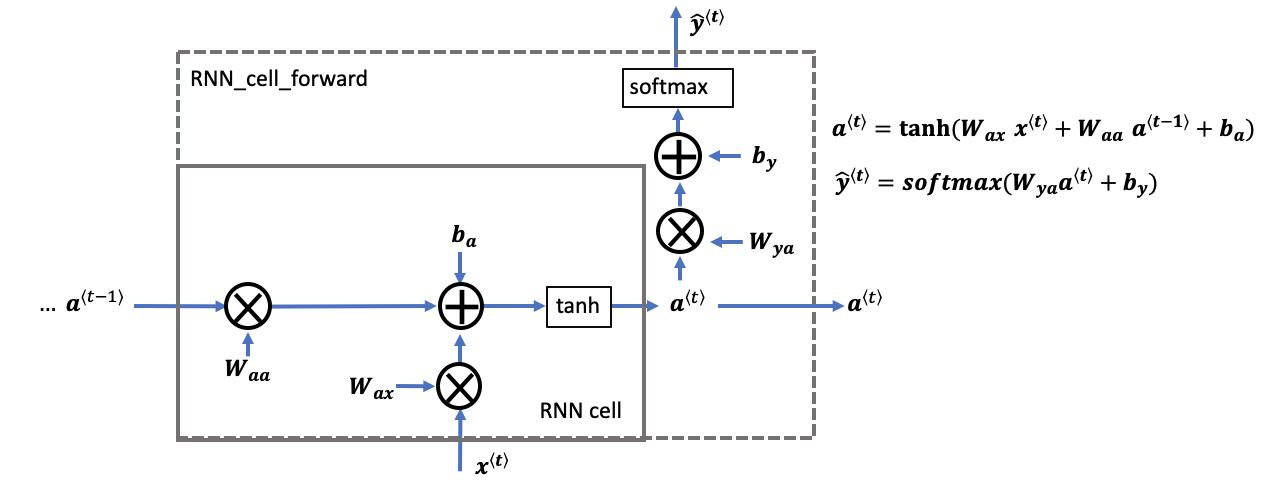

In [15]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.tanh = nn.Tanh()
    self.h2o = nn.Linear(hidden_size,output_size)

  def forward(self,input,hidden):
    input_combined = torch.cat((input,hidden),dim=1)
    hidden = self.tanh(self.i2h(input_combined))
    output = self.h2o(hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros((1,self.hidden_size),dtype=torch.float, device=device)


In [16]:
char = 'b'
idx = ch_to_idx[char]
a = torch.zeros((1,1,vocab_size), dtype=torch.float,device=device)
a[0][0][idx] = 1
a

tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [49]:
hidden_size = 128
learning_rate = 0.001
model = RNN(input_size=train_data.vocab_size,hidden_size=hidden_size,output_size=train_data.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),learning_rate)

In [50]:
def sample(model,start_letter='a'):
  model.eval()
  word_size = 0
  h_next = model.initHidden()

  x = h_next.new_zeros([1, train_data.vocab_size]) # x.shape=[1,27]
  idx = ch_to_idx[start_letter]
  x[0][idx] = 1

  pred_char_idx = -1
  indices = []
  newline_idx = train_data.ch_to_idx['\n']
  with torch.no_grad():
    while pred_char_idx != newline_idx and word_size != 50:
      y_pred,h_next = model(x,h_next)            # y_pred.shape=[1, 27] and h_next.shape=[1, 128] 
      probs = torch.softmax(y_pred, dim=1).cpu().numpy().ravel()       # probs.shape=(27,)
      np.random.seed(np.random.randint(1, 5000))
      idx = np.random.choice(train_data.vocab_size, p=probs) #choose a number between np.arrange(train_data.vocab_size) with reagard to probability(probs)
      indices.append(idx)

      # new x is based on y_pred with shape of x
      x = (y_pred == y_pred.max(1)[0]).float()  #torch.max(input, dime) >> the result tuple of two output tensors (max, max_indices)

      word_size += 1
      pred_char_idx = idx
      
    if word_size == 50:
            indices.append(newline_idx)
  return indices



In [51]:
def print_sample(sample_idxs):
  [print(train_data.idx_to_ch[idx],end='') for idx in sample_idxs]  # end='' for avoiding print to jump new line after each word


In [52]:
def train(model, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    print(f'{"-"*20} Epoch {(epoch+1)}/num_epochs {"-"*20}')
    losses = []
    for line_num, (x,y) in enumerate(data_loader):
      model.train()
      x, y = x.to(device), y.to(device)
      h_next = model.initHidden()
      optimizer.zero_grad()
      loss = 0.0
      for i in range(x.shape[1]):  # example :  'saurus' has x.shape=[1, 6, 27] , y.shape=[1,6]
        y_next,h_next = model(x[:,i],h_next)
        loss += criterion(y_next,y[:,i])
             
      if (line_num+1)%100 == 0:
        print_sample(sample(model))
      if (line_num+1)%50 == 0:
        losses.append(loss.item()/x.shape[1])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),5)
      optimizer.step()
    plt.plot(losses)

-------------------- Epoch 1/num_epochs --------------------
h
mlrc
peas
iguccuruoourus
tnxsauruh
mais
ulub
uras
unocnarus
crusahrusourus

mrapiarus
droaamrus
ucosaurus
nmusaurus
-------------------- Epoch 2/num_epochs --------------------
uaos
lras
ucasaerus
mascaurus
urolhurus
sruaaurus
unuc
tiapaurus
biuaurus
ngscusus
ttcauous
tgtcauras
ugicllrus
erus
lrusturus


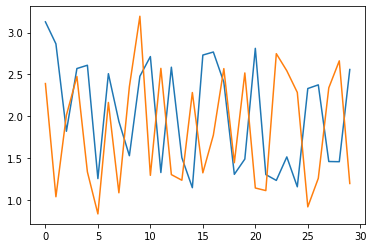

In [54]:
train(model, criterion, optimizer, num_epochs=2)

In [22]:
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.linear_c = nn.Linear(input_size+hidden_size, hidden_size)
    self.linear_u = nn.Linear(input_size+hidden_size, hidden_size)
    self.linear_f = nn.Linear(input_size+hidden_size, hidden_size)
    self.linear_o = nn.Linear(input_size+hidden_size, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)

  def forward(self,x,h_prev,c_prev):
    combined = torch.cat([x, h_prev], 1)
    c_tilde = torch.tanh(self.linear_c(combined))
    u = torch.sigmoid(self.linear_u(combined))
    f = torch.sigmoid(self.linear_f(combined))
    o = torch.sigmoid(self.linear_o(combined))
    c = u * c_tilde + f * c_prev
    h = o * torch.tanh(c)
    y = self.h2o(h)

    return y,h,c

  def initHidden(self):
    return torch.zeros((1,self.hidden_size),dtype=torch.float, device=device)



In [23]:
hidden_size = 128
learning_rate = 0.001
model = LSTM(input_size=train_data.vocab_size,hidden_size=hidden_size,output_size=train_data.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),learning_rate)

In [45]:
def sample(model):
  model.eval()
  word_size = 0
  h_next = model.initHidden()
  c_next = model.initHidden()
  x = h_next.new_zeros([1, train_data.vocab_size]) #x.shape=[1,27],the returned Tensor has the same torch.dtype and torch.device as h_next
  rand_start_letter = np.random.randint(1, 27)
  x[0][rand_start_letter] = 1

  pred_char_idx = -1
  indices = []
  newline_idx = train_data.ch_to_idx['\n']
  with torch.no_grad():
    while pred_char_idx != newline_idx and word_size != 50:
      y_pred,h_next,c_next = model(x,h_next,c_next)            # y_pred.shape=[1, 27] and h_next.shape=[1, 128] 
      probs = torch.softmax(y_pred, dim=1).cpu().numpy().ravel()       # probs.shape=(27,)
      np.random.seed(np.random.randint(1, 5000))
      idx = np.random.choice(train_data.vocab_size, p=probs) #choose a number between np.arrange(train_data.vocab_size) with reagard to probability(probs)
      indices.append(idx)

      # new x is based on y_pred with shape of x
      x = torch.zeros_like(y_pred)  #Returns a tensor filled with the scalar value 0, with the same size,type,device,..
      x[0][idx] = 1

      # second option for x , conservative
      # x = (y_pred == y_pred.max(1)[0]).float()    ##torch.max(input, dime) >> the result tuple of two output tensors (max, max_indices)

      word_size += 1
      pred_char_idx = idx
      
    if word_size == 50:
            indices.append(newline_idx)
  return indices



In [46]:
def train(model, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    print(f'{"-"*20} Epoch {(epoch+1)}/num_epochs {"-"*20}')
    losses = []
    for line_num, (x,y) in enumerate(data_loader):
      model.train()
      x, y = x.to(device), y.to(device)
      h_next = model.initHidden()
      c_next = model.initHidden()
      optimizer.zero_grad()
      loss = 0.0
      for i in range(x.shape[1]):  # example :  'saurus' has x.shape=[1, 6, 27] , y.shape=[1,6]
        y_next,h_next,c_next = model(x[:,i],h_next,c_next)
        loss += criterion(y_next,y[:,i])
            
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),5)
      optimizer.step()
      if (line_num+1)%50 == 0:
        losses.append(loss.item()/(x.shape[1]))
      if (line_num+1)%100 == 0:
        print_sample(sample(model))

    plt.plot(losses)

-------------------- Epoch 1/num_epochs --------------------
min
ispanosaurus
igolichosaurus
anterthosaurus
yxieosaurus
ispanosaurus
igomanphosaurus
lodon
nocorosaurux
itacnocelatops
barosaurus
epatobopena
angosaurus
ufeilustosaurus
ucunnosaurus
-------------------- Epoch 2/num_epochs --------------------
machisaurus
lamisaurus
uazping
ymbenes
olosaurus
racerato
edornithoa
imotosaurus
lotosaurus
merasaurus
uikelofelator
anguiglondosaurus
aucodon
ergtonvondosaurus
tarcaosaurus
-------------------- Epoch 3/num_epochs --------------------
eqeus
anxauantavennosaurus
bsthatag
laclodon
lcion
acriatosaurus
ianlqulosaurus
icerimosaurus
ostosaurus
rchasiopus

ilzosaurus
ryaceratops
ucongosaurus
nachisaurus


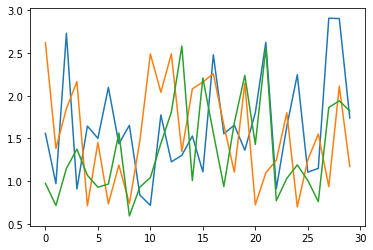

In [47]:
train(model, criterion, optimizer, num_epochs=3)

## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implementation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This assignment had used a relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favorite name is the great, undefeatable, and fierce: Mangosaurus!

<img src="images/mangosaurus.jpeg" style="width:250;height:300px;">

## 4 - Writing like Shakespeare

The rest of this notebook is optional and is not graded, but we hope you'll do it anyway since it's quite fun and informative. 

A similar (but more complicated) task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in the sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 


<img src="images/shakespeare.jpg" style="width:500;height:400px;">
<caption><center> Let's become poets! </center></caption>

We have implemented a Shakespeare poem generator with Keras. Run the following cell to load the required packages and models. This may take a few minutes. 

In [ ]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

To save you some time, we have already trained a model for ~1000 epochs on a collection of Shakespearian poems called [*"The Sonnets"*](shakespeare.txt). 

Let's train the model for one more epoch. When it finishes training for an epoch---this will also take a few minutes---you can run `generate_output`, which will prompt asking you for an input (`<`40 characters). The poem will start with your sentence, and our RNN-Shakespeare will complete the rest of the poem for you! For example, try "Forsooth this maketh no sense " (don't enter the quotation marks). Depending on whether you include the space at the end, your results might also differ--try it both ways, and try other inputs as well. 


In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

In [ ]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

The RNN-Shakespeare model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 

If you want to learn more, you can also check out the Keras Team's text generation implementation on GitHub: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py.

Congratulations on finishing this notebook! 

**References**:
- This exercise took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 